In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.svm import SVR
from sklearn.neural_network import MLPRegressor
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
import xgboost as xgb
import lightgbm as lgb
from surprise import SVD, Dataset, Reader
import datetime

### Load data

In [2]:
df = pd.read_csv("../data/data_cleaned.csv", low_memory=False)
df.head()

,Runner ID,First Name,Surname,Nat.,Gender,Age,Age Group,Cat,YOB,Race Count,...,Cat. Rank,Finish Percentage,Performance Ratio,Distance/Time,Distance KM,Terrain,Time Seconds Finish,Distance Finish,Average Speed,Avg.Speed km/h
0,146799,David,Papineau,CAN,M,42.0,40-49,M40,1968.0,0,...,1.0,0.02,1.000000,50km,50.0,road,13911.0,NaN,278.22,12.939
1,35382,Hassan,Lotfi-Pour,CAN,M,42.0,40-49,M40,1968.0,0,...,2.0,0.04,0.985827,50km,50.0,road,14111.0,NaN,282.22,12.756
2,11991,Ryne,Melcher,CAN,M,31.0,30-39,M23,1979.0,0,...,1.0,0.05,0.985827,50km,50.0,road,14111.0,NaN,282.22,12.756
3,37142,Gary,Robbins,CAN,M,34.0,30-39,M23,1976.0,0,...,2.0,0.07,0.966377,50km,50.0,road,14395.0,NaN,287.90,12.504
4,746071,Rian,O'Maol Chonaire,CAN,M,33.0,30-39,M23,1977.0,0,...,3.0,0.09,0.920040,50km,50.0,road,15120.0,NaN,302.40,11.905


### Aggregated stats
Calculates runners aggregated and some average stats of their races prior to their current race. Running in parallel due to size of dataset

In [7]:
def aggregate_runner_data(group, current_date):
    current_date = pd.to_datetime(current_date)
    
    # Sort the group by date and filter to include only events before the current date
    prior_events = group[pd.to_datetime(group['Date']) < current_date].sort_values('Date')
    
    # If there are no prior events, return default values
    if prior_events.empty:
        return pd.Series({
            'Avg_Performance_Ratio': np.nan,
            'Avg_Finish_Percentage': np.nan,
            'Total_Races': 0,
            'Total_Distance': 0,
            'Preferred_Terrain': 'Unknown',
            'Avg_Speed': np.nan,
            'Days_Since_Last_Race': np.nan,
            'Is_First_Race': True
        })
    
    # Calculate aggregates based on prior events
    aggregates = {
        'Avg_Performance_Ratio': prior_events['Performance Ratio'].mean(),
        'Avg_Finish_Percentage': prior_events['Finish Percentage'].mean(),
        'Total_Races': len(prior_events),
        'Total_Distance': prior_events['Distance KM'].sum(),
        'Preferred_Terrain': prior_events['Terrain'].mode().iloc[0] if not prior_events['Terrain'].mode().empty else 'Unknown',
        'Avg_Speed': prior_events['Avg.Speed km/h'].mean(),
        'Days_Since_Last_Race': (current_date - pd.to_datetime(prior_events['Date'].iloc[-1])).days,
        'Is_First_Race': False
    }
    
    return pd.Series(aggregates)

def process_dataset(data):
    # Ensure the Date column is in datetime format
    data['Date'] = pd.to_datetime(data['Date'])
    
    # Sort the entire dataset by Date
    data = data.sort_values('Date')
    
    # Create a new dataframe to store the results
    result = pd.DataFrame()
    
    # Process each row
    for index, row in data.iterrows():
        runner_data = data[data['Runner ID'] == row['Runner ID']]
        aggregated_data = aggregate_runner_data(runner_data, row['Date'])
        
        # Combine the original row with the aggregated data
        combined_row = pd.concat([row, aggregated_data])
        result = pd.concat([result, combined_row.to_frame().T], ignore_index=True)
    
    return result

In [128]:
# Only looking at distance based events initially 
df_clean = df[df['Event Type']=='Distance']
df_clean = df_clean[pd.to_datetime(df_clean['Date'])>=("2020-01-01")]
df_clean.head()

,Runner ID,First Name,Surname,Nat.,Gender,Age,Age Group,Cat,YOB,Race Count,...,Cat. Rank,Finish Percentage,Performance Ratio,Distance/Time,Distance KM,Terrain,Time Seconds Finish,Distance Finish,Average Speed,Avg.Speed km/h
4257370,1182163,Feng (刘峰),Liu,CHN,M,30.0,30-39,M23,1990.0,3,...,1.0,0.01,1.000000,100km,100.0,trail,46917.0,NaN,469.17,7.673
4257371,754880,Chun-Lu (黄春路 ),Huang,CHN,M,38.0,30-39,M35,1982.0,2,...,1.0,0.03,0.992511,100km,100.0,trail,47271.0,NaN,472.71,7.616
4257372,1454464,Zhen (罗桢),Luo,CHN,M,20.0,20-29,MU23,2000.0,2,...,1.0,0.04,0.978253,100km,100.0,trail,47960.0,NaN,479.60,7.506
4257373,1571753,Ye-Chu,He,CHN,M,33.0,30-39,M23,1987.0,0,...,2.0,0.06,0.940805,100km,100.0,trail,49869.0,NaN,498.69,7.219
4257374,836848,Yan-Ping (韦艳萍),Wei,CHN,F,48.0,40-49,W45,1972.0,13,...,1.0,0.07,0.934471,100km,100.0,trail,50207.0,NaN,502.07,7.170


In [ ]:
df_clean = process_dataset(df_clean)

### Race difficulty weighting

In [13]:
def aggregate_by_event(df):
    agg_data = df.groupby('Event ID').agg({
        'Distance KM': 'first',
        'Elevation Gain': 'first',
        'Terrain': 'first',
        'Male Finishers': 'first',
        'Female Finishers': 'first',
        'Total Finishers': 'first',
        'Time Seconds Winner': 'first',
        'Time Seconds Finish': 'mean'
    }).reset_index()
    
    # Calculate average time
    agg_data['Average Time Seconds'] = agg_data['Time Seconds Finish']
    
    # Calculate winner and average pace
    agg_data['Winner Pace'] = agg_data['Time Seconds Winner'] / 60 / agg_data['Distance KM']
    agg_data['Average Pace'] = agg_data['Average Time Seconds'] / 60 / agg_data['Distance KM']
    agg_data['Gender Ratio'] = agg_data['Male Finishers'] / agg_data['Total Finishers']
    
    return agg_data

# Apply aggregation
df_event = aggregate_by_event(df_clean)

In [14]:
def sigmoid_normalize(x, midpoint, steepness=1):
    return 1 / (1 + np.exp(-steepness * (x - midpoint)))

def calculate_race_difficulty(df, weights):
    # Normalize factors
    distance_factor = sigmoid_normalize(df['Distance KM'], midpoint=100, steepness=0.05)
    elevation_factor = sigmoid_normalize(df['Elevation Gain'], midpoint=2500, steepness=0.001)
    terrain_factor = {'road': 0.6, 'track': 0.4, 'trail': 1.0, 'other': 0.5}[df['Terrain']]
    finishers_factor = max(1 - (df['Total Finishers'] / 1000), 0.5)
    gender_factor = df['Gender Ratio']
    
    # Calculate difficulty score using provided weights
    difficulty_score = (
        distance_factor * weights['distance'] +
        elevation_factor * weights['elevation'] +
        terrain_factor * weights['terrain'] +
        finishers_factor * weights['finishers'] +
        gender_factor * weights['gender']
    )
    
    return difficulty_score


In [15]:
weights = {
    'distance': 0.3,
    'elevation': 0.3,
    'terrain': 0.2,
    'finishers': 0.1,
    'gender': 0.1
}

df_event['Race Difficulty Score'] = df_event.apply(calculate_race_difficulty, weights=weights, axis=1)

In [16]:
df_event.head()

,Event ID,Distance KM,Elevation Gain,Terrain,Male Finishers,Female Finishers,Total Finishers,Time Seconds Winner,Time Seconds Finish,Average Time Seconds,Winner Pace,Average Pace,Gender Ratio,Race Difficulty Score
0,6532,50.0,NaN,trail,38,18,56,11001.0,20887.517857,20887.517857,3.667000,6.962506,0.678571,NaN
1,13158,50.0,NaN,road,52,19,71,17435.0,26432.577465,26432.577465,5.811667,8.810859,0.732394,NaN
2,17736,160.0,NaN,trail,7,1,8,99276.0,107101.375000,107101.375000,10.341250,11.156393,0.875000,NaN
3,22000,50.0,NaN,trail,96,49,145,15061.0,25941.531034,25941.531034,5.020333,8.647177,0.662069,NaN
4,29073,50.0,NaN,road,18,4,22,18960.0,25309.727273,25309.727273,6.320000,8.436576,0.818182,NaN


In [17]:
# Remove events with missing elevation data
agg_df_filtered = df_event.dropna()

print(f"Original number of events: {len(df_event)}")
print(f"Number of events with elevation data: {len(agg_df_filtered)}")
print(f"Number of events removed: {len(df_event) - len(agg_df_filtered)}")

Original number of events: 3698
Number of events with elevation data: 1610
Number of events removed: 2088


In [18]:
# Initial weights
initial_weights = {
    'distance': -0.3,
    'elevation': -0.3,
    'terrain': -0.2,
    'finishers': -0.1
}

# Calculate initial difficulty scores
agg_df_filtered['Race Difficulty Score'] = agg_df_filtered.apply(lambda row: calculate_race_difficulty(row, initial_weights), axis=1)

def optimize_difficulty_score(df):
    # Prepare features
    X = df[['Distance KM', 'Elevation Gain', 'Total Finishers']]
    X['Terrain'] = df['Terrain'].map({'road': 0.6, 'track': 0.4, 'trail': 1.0, 'other': 0.5})
    
    # Normalize features
    X['Distance KM'] = sigmoid_normalize(X['Distance KM'], midpoint=100, steepness=0.05)
    X['Elevation Gain'] = sigmoid_normalize(X['Elevation Gain'], midpoint=2500, steepness=0.001)
    X['Total Finishers'] = sigmoid_normalize(X['Total Finishers'], midpoint=500, steepness=0.01)
    
    # Use a combination of winner pace and average pace as the target
    y = 1 / (0.7 * df['Winner Pace'] + 0.3 * df['Average Pace'])
    
    # Split data
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
    
    # Train model
    model = LinearRegression()
    model.fit(X_train, y_train)
    
    # Evaluate model
    y_pred = model.predict(X_test)
    mse = mean_squared_error(y_test, y_pred)
    print(f"Mean Squared Error: {mse}")
    
    # Get optimized weights
    weights = {
        'distance': model.coef_[0],
        'elevation': model.coef_[1],
        'finishers': model.coef_[2],
        'terrain': model.coef_[3]
    }
    print("Optimized weights:", weights)
    
    return weights

KeyError: 'gender'

In [ ]:
# Optimize weights
optimized_weights = optimize_difficulty_score(agg_df_filtered)

# Recalculate difficulty scores with optimized weights
agg_df_filtered['Optimized Difficulty Score'] = agg_df_filtered.apply(lambda row: calculate_race_difficulty(row, optimized_weights), axis=1)

# Compare correlation
baseline_difficulty = 1 / (0.7 * agg_df_filtered['Winner Pace'] + 0.3 * agg_df_filtered['Average Pace'])
initial_correlation = agg_df_filtered['Race Difficulty Score'].corr(baseline_difficulty)
optimized_correlation = agg_df_filtered['Optimized Difficulty Score'].corr(baseline_difficulty)

print(f"Initial correlation: {initial_correlation}")
print(f"Optimized correlation: {optimized_correlation}")

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

# Set up the plotting style
#plt.style.use('seaborn')

# 1. Scatter plot of initial difficulty score vs. baseline difficulty
plt.figure(figsize=(10, 6))
plt.scatter(agg_df_filtered['Race Difficulty Score'], baseline_difficulty, alpha=0.6)
plt.xlabel('Initial Race Difficulty Score')
plt.ylabel('Baseline Difficulty (based on pace)')
plt.title('Initial Difficulty Score vs. Baseline Difficulty')
plt.plot([0, 1], [0, 1], color='r', linestyle='--')  # Add a diagonal line for reference
plt.tight_layout()
plt.show()

# 2. Scatter plot of optimized difficulty score vs. baseline difficulty
plt.figure(figsize=(10, 6))
plt.scatter(agg_df_filtered['Optimized Difficulty Score'], baseline_difficulty, alpha=0.6)
plt.xlabel('Optimized Race Difficulty Score')
plt.ylabel('Baseline Difficulty (based on pace)')
plt.title('Optimized Difficulty Score vs. Baseline Difficulty')
plt.plot([0, 1], [0, 1], color='r', linestyle='--')  # Add a diagonal line for reference
plt.tight_layout()
plt.show()

# 3. Distribution of difficulty scores before and after optimization
plt.figure(figsize=(12, 6))
sns.kdeplot(data=agg_df_filtered['Race Difficulty Score'], shade=True, label='Initial Score')
sns.kdeplot(data=agg_df_filtered['Optimized Difficulty Score'], shade=True, label='Optimized Score')
plt.xlabel('Difficulty Score')
plt.ylabel('Density')
plt.title('Distribution of Difficulty Scores: Initial vs. Optimized')
plt.legend()
plt.tight_layout()
plt.show()

# 4. Bar plot of initial and optimized weights
weights_df = pd.DataFrame({
    'Initial': initial_weights,
    'Optimized': optimized_weights
})

plt.figure(figsize=(10, 6))
weights_df.plot(kind='bar')
plt.title('Comparison of Initial and Optimized Weights')
plt.xlabel('Factors')
plt.ylabel('Weight')
plt.legend(title='Weights')
plt.tight_layout()
plt.show()

# 5. Residual plot for the optimized model
residuals = baseline_difficulty - agg_df_filtered['Optimized Difficulty Score']
plt.figure(figsize=(10, 6))
plt.scatter(agg_df_filtered['Optimized Difficulty Score'], residuals, alpha=0.6)
plt.xlabel('Optimized Difficulty Score')
plt.ylabel('Residuals')
plt.title('Residual Plot for Optimized Difficulty Score')
plt.axhline(y=0, color='r', linestyle='--')
plt.tight_layout()
plt.show()

# 6. Difficulty score vs. race distance
plt.figure(figsize=(12, 6))
plt.scatter(agg_df_filtered['Distance KM'], agg_df_filtered['Optimized Difficulty Score'], alpha=0.6)
plt.xlabel('Race Distance (km)')
plt.ylabel('Optimized Difficulty Score')
plt.title('Race Difficulty vs. Distance')
plt.tight_layout()
plt.show()

# Print summary statistics
print("Summary Statistics for Optimized Difficulty Score:")
print(agg_df_filtered['Optimized Difficulty Score'].describe())

# Print correlation matrix
correlation_matrix = agg_df_filtered[['Distance KM', 'Elevation Gain', 'Total Finishers', 'Optimized Difficulty Score']].corr()
print("\nCorrelation Matrix:")
print(correlation_matrix)

In [ ]:
optimized_weights = weights_df['Optimized'].to_dict()
df_event['Optimised Difficulty Score'] = df_event.apply(calculate_race_difficulty, weights=optimized_weights, axis=1)
df_event.head()

In [ ]:
if 'Race Difficulty Score' in df_event.columns:
    print("Correlation between original and optimized difficulty scores:")
    print(df_event['Race Difficulty Score'].corr(df_event['Optimised Difficulty Score']))

    # Visualize the difference
    plt.figure(figsize=(10, 6))
    plt.scatter(df_event['Race Difficulty Score'], df_event['Optimised Difficulty Score'], alpha=0.6)
    plt.xlabel('Original Difficulty Score')
    plt.ylabel('Optimised Difficulty Score')
    plt.title('Original vs. Optimised Difficulty Scores')
    plt.plot([0, 1], [0, 1], color='r', linestyle='--')  # Add a diagonal line for reference
    plt.tight_layout()
    plt.show()

# Print summary statistics of the new difficulty scores
print("\nSummary statistics of Optimised Difficulty Scores:")
print(df_event['Optimised Difficulty Score'].describe())

# Visualize the distribution of new difficulty scores
plt.figure(figsize=(10, 6))
sns.histplot(df_event['Optimised Difficulty Score'], kde=True)
plt.title('Distribution of Optimised Difficulty Scores')
plt.xlabel('Difficulty Score')
plt.ylabel('Frequency')
plt.show()

In [ ]:
def invert_and_normalize(scores, scale_to_100=False):
    # Invert the scores
    inverted_scores = -scores
    
    # Apply min-max normalization
    normalised = (inverted_scores - inverted_scores.min()) / (inverted_scores.max() - inverted_scores.min())
    
    # Scale to 0-100 range if requested
    if scale_to_100:
        normalised = normalised * 100
    
    return normalised

# Apply the inversion and normalization
df_event['Normalised Difficulty Score'] = invert_and_normalize(df_event['Optimised Difficulty Score'])

# Visualize the results
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))

# Original Optimised Difficulty Scores
sns.histplot(df_event['Optimised Difficulty Score'], kde=True, ax=ax1)
ax1.set_title('Original Optimised Difficulty Scores')
ax1.set_xlabel('Score')

# Normalised Difficulty Scores
sns.histplot(df_event['Normalised Difficulty Score'], kde=True, ax=ax2)
ax2.set_title('Normalised Difficulty Scores (0-100)')
ax2.set_xlabel('Score')

plt.tight_layout()
plt.show()

# Print summary statistics
print("\nSummary statistics for Original Optimised Difficulty Score:")
print(df_event['Optimised Difficulty Score'].describe())

print("\nSummary statistics for Normalised Difficulty Score:")
print(df_event['Normalised Difficulty Score'].describe())

# Scatter plot to compare original and normalised scores
plt.figure(figsize=(10, 6))
plt.scatter(df_event['Optimised Difficulty Score'], df_event['Normalised Difficulty Score'], alpha=0.6)
plt.xlabel('Original Optimised Difficulty Score')
plt.ylabel('Normalised Difficulty Score')
plt.title('Original vs. Normalised Difficulty Scores')
plt.tight_layout()
plt.show()

# Display the top 10 most difficult races
print("\nTop 10 Most Difficult Races:")
top_10 = df_event.nlargest(10, 'Normalised Difficulty Score')[['Event ID', 'Normalised Difficulty Score', 'Distance KM', 'Elevation Gain']]
print(top_10)

# Display the bottom 10 least difficult races
print("\nBottom 10 Least Difficult Races:")
bottom_10 = df_event.nsmallest(10, 'Normalised Difficulty Score')[['Event ID', 'Normalised Difficulty Score', 'Distance KM', 'Elevation Gain']]
print(bottom_10)

In [130]:
df_clean = df.merge(df_event[['Event ID', 'Normalised Difficulty Score']], on='Event ID', how='left')
df_clean['Inverse Time'] = 1 / (df_clean['Time Seconds Finish'] / 60)
df_clean['Weighted Performance'] = df_clean['Time Seconds Finish'] * df_clean['Normalised Difficulty Score']


In [ ]:
df_clean.columns

In [139]:
df_clean.sample(10)

### Random Forest

In [ ]:
features = df_clean.groupby('Runner ID').agg(
    average_time=('Time Seconds Finish', 'mean'),
    min_time=('Time Seconds Finish', 'min'),
    max_time=('Time Seconds Finish', 'max'),
    count_races=('Time Seconds Finish', 'count'),
    avg_percentile=('Finish Percentage', 'mean'),
    max_percentile=('Finish Percentage', 'max'),
    min_percentile=('Finish Percentage', 'min'),
    avg_speed=('Average Speed', 'mean'),
    max_speed=('Average Speed', 'max'),
    min_speed=('Average Speed', 'min'),
    #race_difficulty=('Normalised Difficulty Score', 'mean'),
    #weighted_performance=('Weighted Performance', 'mean')
).reset_index()

features.head()

In [ ]:
data = df_clean

# Function to aggregate runner data
def aggregate_runner_data(group):
    return pd.Series({
        'Avg_Performance_Ratio': group['Performance Ratio'].mean(),
        'Avg_Finish_Percentage': group['Finish Percentage'].mean(),
        'Total_Races': len(group),
        'Total_Distance': group['Distance KM'].sum(),
        'Preferred_Terrain': group['Terrain'].mode().iloc[0],
        #'Avg_Normalised_Difficulty': group['Normalised Difficulty Score'].mean(),
        'Avg_Speed': group['Avg.Speed km/h'].mean()
    })

# Aggregate runner data
runner_data = data.groupby('Runner ID').apply(aggregate_runner_data).reset_index()

# Merge aggregated data back with original data
merged_data = pd.merge(data, runner_data, on='Runner ID', suffixes=('', '_history'))

# Select features and target
features = [
    'Distance KM', 'Elevation Gain', 'Terrain', 'Total Finishers', 
    #'Normalised Difficulty Score', 
    'Avg_Performance_Ratio', 'Avg_Finish_Percentage',
    'Total_Races', 'Total_Distance', 'Preferred_Terrain', #'Avg_Normalised_Difficulty',
    'Avg_Speed', 'Age', 'Gender'
]
target = 'Time Seconds Finish'

# Remove rows with NaN values in features or target
merged_data_clean = merged_data.dropna(subset=features + [target])

In [195]:
# Prepare the features and target
X = merged_data_clean[features]
y = merged_data_clean[target]

# Handle missing values
X = X.fillna({
    'Avg_Performance_Ratio': X['Avg_Performance_Ratio'].mean(),
    'Avg_Finish_Percentage': X['Avg_Finish_Percentage'].mean(),
    'Total_Races': 0,
    'Total_Distance': 0,
    'Preferred_Terrain': 'Unknown',
    #'Avg_Normalised_Difficulty': X['Avg_Normalised_Difficulty'].mean(),
    'Avg_Speed': X['Avg_Speed'].mean(),
    'Age': X['Age'].median()
})

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Define numeric and categorical features
numeric_features = [
    'Distance KM', 'Elevation Gain', 'Total Finishers', #'Normalised Difficulty Score',
    'Avg_Performance_Ratio', 'Avg_Finish_Percentage', 'Total_Races', 'Total_Distance',
    #'Avg_Normalised_Difficulty', 
    'Avg_Speed', 'Age'
]
categorical_features = ['Terrain', 'Preferred_Terrain', 'Gender']

# Create preprocessing steps
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numeric_features),
        ('cat', OneHotEncoder(drop='first', handle_unknown='ignore'), categorical_features)
    ])

# Create a pipeline with preprocessor and random forest
rf_model = Pipeline([
    ('preprocessor', preprocessor),
    ('regressor', RandomForestRegressor(n_estimators=100, random_state=42))
])

In [ ]:
# Fit the model
rf_model.fit(X_train, y_train)

# Make predictions on the test set
y_pred = rf_model.predict(X_test)

# Evaluate the model
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f"Mean Squared Error: {mse}")
print(f"R-squared Score: {r2}")

In [ ]:
plt.figure(figsize=(10, 6))
plt.scatter(y_test, y_pred, alpha=0.5)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2)
plt.xlabel("Actual Values")
plt.ylabel("Predicted Values")
plt.title("Random Forest: Predicted vs Actual Values")

# Add text with metrics
plt.text(0.05, 0.95, f'R2: {r2:.2f}\nMSE: {mse:.2f}', 
         transform=plt.gca().transAxes, verticalalignment='top')

plt.tight_layout()
plt.show()

# Calculate residuals
residuals = y_test - y_pred

# Plot residuals
plt.figure(figsize=(10, 6))
plt.scatter(y_pred, residuals, alpha=0.5)
plt.xlabel("Predicted Values")
plt.ylabel("Residuals")
plt.title("Random Forest: Residuals Plot")
plt.axhline(y=0, color='r', linestyle='--')
plt.tight_layout()
plt.show()


In [ ]:
feature_names = (numeric_features + 
                 [f"{feature}_{category}" for feature, categories in 
                  zip(categorical_features, 
                      rf_model.named_steps['preprocessor']
                      .named_transformers_['cat']
                      .categories_) 
                  for category in categories[1:]])

# Get feature importances
importances = rf_model.named_steps['regressor'].feature_importances_

# Sort feature importances in descending order
indices = np.argsort(importances)[::-1]

# Print the feature ranking
print("Feature ranking:")
for f in range(X.shape[1]):
    print("%d. %s (%f)" % (f + 1, feature_names[indices[f]], importances[indices[f]]))

In [200]:
def generate_runner_history(data, runner_id):
    # Filter data for the specific runner
    runner_data = data[data['Runner ID'] == runner_id]
    
    if runner_data.empty:
        print(f"No data found for Runner ID: {runner_id}")
        return None
    
    # Calculate aggregate statistics
    history = {
        'avg_performance_ratio': runner_data['Performance Ratio'].mean(),
        'avg_finish_percentage': runner_data['Finish Percentage'].mean(),
        'total_races': len(runner_data),
        'total_distance': runner_data['Distance KM'].sum(),
        'preferred_terrain': runner_data['Terrain'].mode().iloc[0] if not runner_data['Terrain'].mode().empty else 'Unknown',
        #'avg_normalised_difficulty': runner_data['Normalised Difficulty Score'].mean(),
        'avg_speed': runner_data['Avg.Speed km/h'].mean(),
        'age': runner_data['Age'].iloc[-1] if 'Age' in runner_data.columns else np.nan,
        'gender': runner_data['Gender'].iloc[0] if 'Gender' in runner_data.columns else 'Unknown'
    }
    
    # Additional statistics
    history['best_performance_ratio'] = runner_data['Performance Ratio'].max()
    history['worst_performance_ratio'] = runner_data['Performance Ratio'].min()
    history['avg_elevation_gain_per_km'] = runner_data['Elevation Gain'].sum() / history['total_distance']
    history['favorite_distance'] = runner_data['Distance KM'].mode().iloc[0]
    history['avg_rank_percentage'] = runner_data['Rank'].mean() / runner_data['Total Finishers'].mean()
    
    # Calculate improvement trend (using last 5 races if available)
    last_5_races = runner_data.sort_values('Date').tail(5)
    if len(last_5_races) >= 2:
        performance_trend = np.polyfit(range(len(last_5_races)), last_5_races['Performance Ratio'], 1)[0]
        history['performance_trend'] = performance_trend
    else:
        history['performance_trend'] = 0
    
    # Handle potential NaN values
    for key, value in history.items():
        if pd.isna(value):
            if key in ['age', 'total_races', 'total_distance']:
                history[key] = 0
            elif key in ['avg_performance_ratio', 'avg_finish_percentage', 'avg_speed']:
                history[key] = data[key.replace('avg_', '')].mean()
            else:
                history[key] = 'Unknown'
    
    return history

# Example usage:
# Assuming 'data' is your DataFrame containing all race results
# runner_id = 12345  # Replace with an actual Runner ID from your dataset
# runner_history = generate_runner_history(data, runner_id)
# print(runner_history)

In [203]:
# Function to make predictions
def predict_finish_time(runner_history, race_details):
    input_data = pd.DataFrame({
        'Distance KM': [race_details['distance']],
        'Elevation Gain': [race_details['elevation_gain']], 
        'Terrain': [race_details['terrain']],
        'Total Finishers': [race_details['total_finishers']],
        #'Normalised Difficulty Score': [race_details['difficulty_score']],
        'Avg_Performance_Ratio': [runner_history['avg_performance_ratio']],
        'Avg_Finish_Percentage': [runner_history['avg_finish_percentage']],
        'Total_Races': [runner_history['total_races']],
        'Total_Distance': [runner_history['total_distance']],
        'Preferred_Terrain': [runner_history['preferred_terrain']],
        #'Avg_Normalised_Difficulty': [runner_history['avg_normalised_difficulty']],
        'Avg_Speed': [runner_history['avg_speed']],
        'Age': [runner_history['age']],
        'Gender': [runner_history['gender']]
    })
    prediction = rf_model.predict(input_data)
    return prediction[0]

In [ ]:
runner_history = generate_runner_history(merged_data, '1311188')

race_details = {
    'distance': 101,
    'elevation_gain': 6050,
    'terrain': 'trail',
    'total_finishers': 1636,
    #'difficulty_score': 0.71
}

example_prediction = predict_finish_time(runner_history, race_details)
example_prediction = str(datetime.timedelta(seconds=example_prediction))
print(f"Predicted finish time: {example_prediction}")

In [22]:
df_clean.columns

Index(['Runner ID', 'First Name', 'Surname', 'Nat.', 'Gender', 'Age',
       'Age Group', 'Cat', 'YOB', 'Race Count', 'Cumulative Distance KM',
       'Event ID', 'Event', 'Event Type', 'Date', 'Race Location',
       'Elevation Gain', 'Elevation Gain per KM', 'Total Finishers',
       'Male Finishers', 'Female Finishers', 'Time Seconds Winner',
       'Distance Winner', 'Rank', 'Rank M/F', 'Cat. Rank', 'Finish Percentage',
       'Performance Ratio', 'Distance/Time', 'Distance KM', 'Terrain',
       'Time Seconds Finish', 'Distance Finish', 'Average Speed',
       'Avg.Speed km/h'],
      dtype='object')

### Collaborative filtering

In [129]:
df_collab = df_clean[df_clean['Elevation Gain'].notna()]

# Step 2: Extract relevant features
def extract_features(row):
    return pd.Series({
        'Runner ID': row['Runner ID'],
        'Distance': row['Distance KM'],
        'Elevation': row['Elevation Gain'],
        'Terrain': row['Terrain'],
        #'Country': row['Race Location'],
        'Time': row['Time Seconds Finish'],
        'Date': row['Date']  # Include date to differentiate between races
    })

race_features = df_collab.apply(extract_features, axis=1)

# Step 3: Create bins for distance and elevation
def create_distance_bin(distance):
    return f"{int(distance // 10 * 10)}-{int((distance // 10 + 1) * 10)}km"

def create_elevation_bin(elevation):
    return f"{int(elevation // 200 * 200)}-{int((elevation // 200 + 1) * 200)}m"

race_features['Distance_Bin'] = race_features['Distance'].apply(create_distance_bin)
race_features['Elevation_Bin'] = race_features['Elevation'].apply(create_elevation_bin)

# Step 4: Encode categorical variables
categorical_columns = ['Terrain', 'Distance_Bin', 'Elevation_Bin']
race_features_encoded = pd.get_dummies(race_features, columns=categorical_columns)

# Step 5: Standardize numerical features
scaler = StandardScaler()
numerical_features = ['Distance', 'Elevation']
race_features_encoded[numerical_features] = scaler.fit_transform(race_features_encoded[numerical_features])

# Step 6: Cluster races
n_clusters = 50
kmeans = KMeans(n_clusters=n_clusters, random_state=42)
clustering_features = race_features_encoded.drop(['Runner ID', 'Time', 'Date'], axis=1)
race_features_encoded['Cluster'] = kmeans.fit_predict(clustering_features)


In [130]:
race_features_encoded.head()

,Runner ID,Distance,Elevation,Time,Date,Terrain_other,Terrain_road,Terrain_track,Terrain_trail,Distance_Bin_0-10km,...,Elevation_Bin_8200-8400m,Elevation_Bin_8400-8600m,Elevation_Bin_8600-8800m,Elevation_Bin_8800-9000m,Elevation_Bin_9000-9200m,Elevation_Bin_9200-9400m,Elevation_Bin_9400-9600m,Elevation_Bin_9600-9800m,Elevation_Bin_9800-10000m,Cluster
4258077,1091769,-0.65829,-0.594041,13842.0,2020-01-04,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,34
4258078,623228,-0.65829,-0.594041,15015.0,2020-01-04,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,34
4258079,1442813,-0.65829,-0.594041,16865.0,2020-01-04,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,34
4258080,1238254,-0.65829,-0.594041,17387.0,2020-01-04,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,34
4258081,1442814,-0.65829,-0.594041,18833.0,2020-01-04,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,34


In [131]:
# Step 7: Create User-Item Matrix
def create_user_item_matrix(df):
    # Group by Runner ID and Cluster, then aggregate
    grouped = df.groupby(['Runner ID', 'Cluster'])
    
    # Calculate statistics for each runner-cluster combination
    agg_data = grouped.agg({
        'Time': ['count', 'mean', 'min', 'max', 'std']
    })
    
    # Flatten column names
    agg_data.columns = ['_'.join(col).strip() for col in agg_data.columns.values]
    
    # Unstack the DataFrame to create the matrix
    user_item_matrix = agg_data.unstack(level='Cluster')
    
    # Flatten column names again
    user_item_matrix.columns = [f'{stat}_{cluster}' for stat, cluster in user_item_matrix.columns]
    
    return user_item_matrix

user_item_matrix = create_user_item_matrix(race_features_encoded)

# Print some information about the user-item matrix
print("User-Item Matrix Shape:", user_item_matrix.shape)
print("\nFirst few rows of the User-Item Matrix:")
print(user_item_matrix.head())
print("\nNumber of unique runners:", user_item_matrix.index.nunique())
print("Number of features per cluster:", len(user_item_matrix.columns) // n_clusters)

# Optional: Fill NaN values
user_item_matrix = user_item_matrix.fillna(0)

# Now you have a user-item matrix where each cell contains multiple statistics
# about a runner's performance in a particular race cluster

User-Item Matrix Shape: (539375, 250)

First few rows of the User-Item Matrix:
           Time_count_0  Time_count_1  Time_count_2  Time_count_3  \
Runner ID                                                           
1                   NaN           NaN           NaN           NaN   
1000005             NaN           NaN           NaN           NaN   
1000007             NaN           NaN           NaN           NaN   
1000009             NaN           NaN           NaN           NaN   
1000016             NaN           NaN           NaN           NaN   

           Time_count_4  Time_count_5  Time_count_6  Time_count_7  \
Runner ID                                                           
1                   NaN           NaN           NaN           NaN   
1000005             NaN           NaN           NaN           NaN   
1000007             NaN           NaN           NaN           NaN   
1000009             NaN           NaN           NaN           NaN   
1000016             NaN

In [132]:
# Step 8: Implement Collaborative Filtering
from sklearn.impute import SimpleImputer
from sklearn.decomposition import TruncatedSVD
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, mean_squared_error
import numpy as np

# Prepare the data
X = user_item_matrix.values
runner_ids = user_item_matrix.index

# Split the data into training and testing sets
X_train, X_test, runner_ids_train, runner_ids_test = train_test_split(X, runner_ids, test_size=0.2, random_state=42)

# Impute missing values
imputer = SimpleImputer(strategy='mean')
X_train_imputed = imputer.fit_transform(X_train)
X_test_imputed = imputer.transform(X_test)

# Perform matrix factorization
n_components = 50 
svd = TruncatedSVD(n_components=n_components, random_state=42)
X_train_factorized = svd.fit_transform(X_train_imputed)


In [161]:
# Step 9: Make predictions
def predict_times(X_factorized, svd_model):
    return np.dot(X_factorized, svd_model.components_)

X_train_pred = predict_times(X_train_factorized, svd)
X_test_factorized = svd.transform(X_test_imputed)
X_test_pred = predict_times(X_test_factorized, svd)

# Step 10: Evaluate the model
def evaluate_predictions(y_true, y_pred):
    mae = mean_absolute_error(y_true, y_pred)
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    r2 = r2_score(y_true, y_pred)
    return mae, rmse, r2

# Evaluate on training set
train_mae, train_rmse, train_r2 = evaluate_predictions(X_train_imputed, X_train_pred)
print(f"Training MAE: {train_mae:.2f}")
print(f"Training RMSE: {train_rmse:.2f}")
print(f"Training R2: {train_r2:.2f}")

# Evaluate on test set
test_mae, test_rmse, test_r2 = evaluate_predictions(X_test_imputed, X_test_pred)
print(f"Test MAE: {test_mae:.2f}")
print(f"Test RMSE: {test_rmse:.2f}")
print(f"Test R2: {test_r2:.2f}")

Training MAE: 25.28
Training RMSE: 430.70
Training R2: 0.77
Test MAE: 25.62
Test RMSE: 461.53
Test R2: 0.77


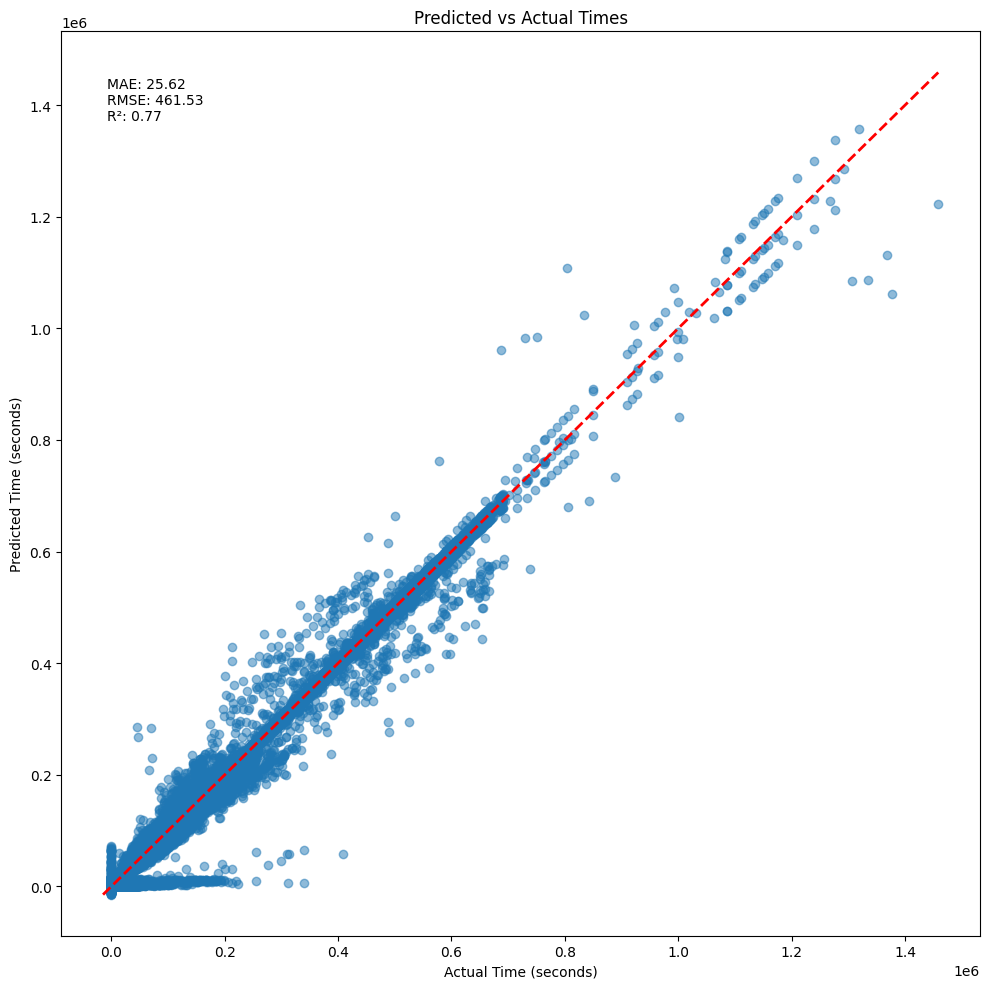

In [162]:
plt.figure(figsize=(10, 10))
plt.scatter(X_train_imputed, X_train_pred, alpha=0.5)

# Add perfect prediction line
max_value = max(np.max(X_train_imputed), np.max(X_train_pred))
min_value = min(np.min(X_train_imputed), np.min(X_train_pred))
plt.plot([min_value, max_value], [min_value, max_value], 'r--', lw=2)

plt.xlabel('Actual Time (seconds)')
plt.ylabel('Predicted Time (seconds)')
plt.title('Predicted vs Actual Times')

# Add metrics to the plot
plt.text(0.05, 0.95, f'MAE: {test_mae:.2f}\nRMSE: {test_rmse:.2f}\nR²: {test_r2:.2f}', 
            transform=plt.gca().transAxes, verticalalignment='top')

plt.tight_layout()
plt.show()

In [138]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans

def get_race_cluster(distance, elevation, terrain):
    # Create a DataFrame for the new race
    new_race = pd.DataFrame({
        'Distance': [distance],
        'Elevation': [elevation],
        'Terrain': [terrain]
        #'Country': [country]
    })
    
    # Create bins for distance and elevation
    new_race['Distance_Bin'] = new_race['Distance'].apply(create_distance_bin)
    new_race['Elevation_Bin'] = new_race['Elevation'].apply(create_elevation_bin)
    
    # Get all possible columns from the training data
    all_columns = clustering_features.columns.tolist()
    
    # Prepare the data for encoding
    data_to_encode = new_race[['Terrain', 'Distance_Bin', 'Elevation_Bin']]
    
    # Perform one-hot encoding
    encoded_cols = pd.get_dummies(data_to_encode)
    
    # Create a DataFrame with all columns from training data, filled with zeros
    new_race_encoded = pd.DataFrame(0, index=new_race.index, columns=all_columns)
    
    # Update the values for the columns that are present in the encoded data
    for col in encoded_cols.columns:
        if col in new_race_encoded.columns:
            new_race_encoded[col] = encoded_cols[col]
    
    # Add 'Distance' and 'Elevation' columns
    new_race_encoded['Distance'] = new_race['Distance']
    new_race_encoded['Elevation'] = new_race['Elevation']
    
    # Ensure the order of columns matches the training data
    new_race_encoded = new_race_encoded[clustering_features.columns]
    
    # Standardize numerical features
    numerical_features = ['Distance', 'Elevation']
    new_race_encoded[numerical_features] = scaler.transform(new_race_encoded[numerical_features])
    
    # Predict the cluster
    cluster = kmeans.predict(new_race_encoded)[0]
    
    return cluster

def predict_for_new_race(runner_id, distance, elevation, terrain, stat='mean'):
    if runner_id not in user_item_matrix.index:
        print(f"Runner {runner_id} not found in the dataset.")
        return None, None
    
    race_cluster = get_race_cluster(distance, elevation, terrain)
    
    # Diagnostic information
    print(f"Predicted cluster: {race_cluster}")
    #print(f"Number of clusters in KMeans model: {kmeans.n_clusters_}")
    print(f"Unique clusters in user-item matrix: {sorted(set([int(col.split('_')[-1]) for col in user_item_matrix.columns if f'Time_{stat}_' in col]))}")
    
    runner_features = user_item_matrix.loc[runner_id].values.reshape(1, -1)
    runner_features_imputed = imputer.transform(runner_features)
    runner_factorized = svd.transform(runner_features_imputed)
    predictions = predict_times(runner_factorized, svd)
    
    column_name = f'Time_{stat}_{race_cluster}'
    if column_name not in user_item_matrix.columns:
        print(f"No data available for Time_{stat} in cluster {race_cluster}")
        
        # Find the nearest available cluster
        available_clusters = [int(col.split('_')[-1]) for col in user_item_matrix.columns if f'Time_{stat}_' in col]
        if not available_clusters:
            print(f"No clusters found for Time_{stat}")
            return None, race_cluster
        nearest_cluster = min(available_clusters, key=lambda x: abs(x - race_cluster))
        print(f"Using nearest available cluster: {nearest_cluster}")
        
        column_name = f'Time_{stat}_{nearest_cluster}'
    
    cluster_index = user_item_matrix.columns.get_loc(column_name)
    predicted_time = predictions[0, cluster_index]
    
    return predicted_time, race_cluster


In [158]:
# Example usage
runner_id = '1409054'
new_race_distance = 159  # km
new_race_elevation = 8200  # meters
new_race_terrain = 'trail'

predicted_time, assigned_cluster = predict_for_new_race(runner_id, new_race_distance, new_race_elevation, new_race_terrain)

if predicted_time is not None:
    print(f"New race assigned to cluster: {assigned_cluster}")
    print(f"Predicted mean time for runner {runner_id}: {predicted_time:.2f} seconds")
else:
    print("Unable to make a prediction.")

# You can also predict min, max, or other stats by changing the 'stat' parameter
predicted_min_time, _ = predict_for_new_race(runner_id, new_race_distance, new_race_elevation, new_race_terrain, stat='min')
if predicted_min_time is not None:
    print(f"Predicted minimum time for runner {runner_id}: {predicted_min_time:.2f} seconds")

Predicted cluster: 26
Unique clusters in user-item matrix: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49]
New race assigned to cluster: 26
Predicted mean time for runner 1409054: 126750.06 seconds
Predicted cluster: 26
Unique clusters in user-item matrix: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49]
Predicted minimum time for runner 1409054: 124618.28 seconds
